PROJECT_ROOT: D:\Users\Coni\Documents\TFM_CirrhosIS
OUT_FILTER  : D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_main_filtered_for_analysis.h5ad
FIG_DIR     : D:\Users\Coni\Documents\TFM_CirrhosIS\figures_final
OUT_SUMMARY : D:\Users\Coni\Documents\TFM_CirrhosIS\summary_tables_final
MAP_PATH    : D:\Users\Coni\Documents\TFM_CirrhosIS\summary_tables_final\Level2_final_map.json

Level2_final_map.json loaded:
{'Conv_T_other': 'CD4_Memory'}

Loaded OUT_FILTER (backed): AnnData object with n_obs × n_vars = 220637 × 38606 backed at 'D:\\Users\\Coni\\Documents\\TFM_CirrhosIS\\data_processed\\TFM_CIRRHOSIS_main_filtered_for_analysis.h5ad'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', '

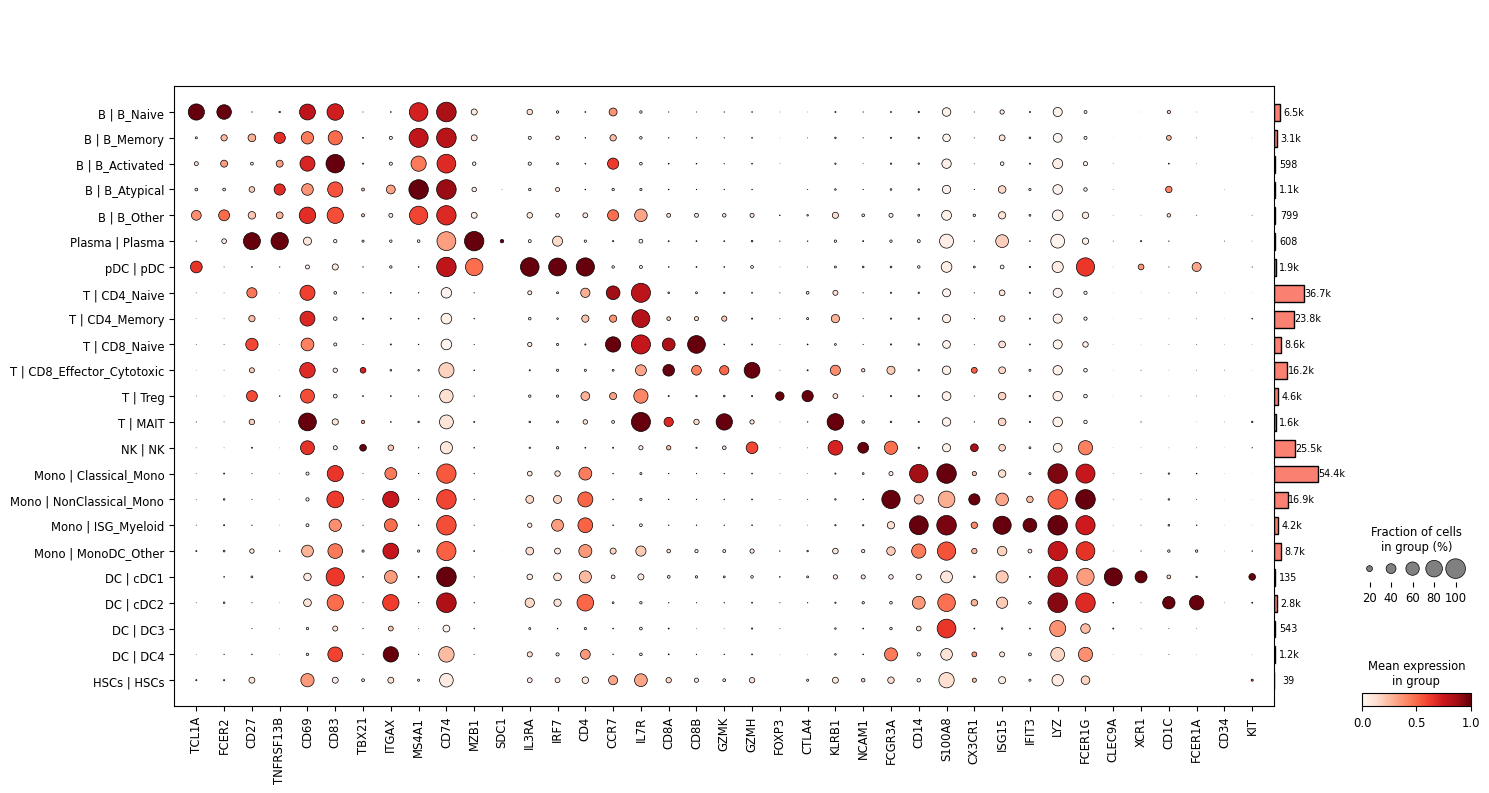

In [1]:
# ============================================================
# correcciones_dotplot_global.ipynb (VERSIÓN LIMPIA post-RBC-out + Level2_final)
# Objetivo:
#   - Generar DOTPLOT GLOBAL FINAL a Level2 (FINAL) desde OUT_FILTER (ya sin RBC)
#   - Memory-safe: abre backed="r" y solo carga ~50 genes a RAM
#   - Aplica Level2_final_map.json (Conv_T_other -> CD4_Memory) para plot/orden/tablas
#   - Guarda: figura PNG + tablas (totales + marcadores usados)
# ============================================================

from pathlib import Path
import sys
import json
import numpy as np
import pandas as pd
import scanpy as sc

# ------------------------------
# 0) Paths / proyecto
# ------------------------------
NOTEBOOK_DIR = Path.cwd()

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data_processed").exists():
            return p
    raise FileNotFoundError(f"No encuentro 'data_processed' subiendo desde: {start}")

PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
DATA_PROCESSED = PROJECT_ROOT / "data_processed"

OUT_FILTER = DATA_PROCESSED / "TFM_CIRRHOSIS_main_filtered_for_analysis.h5ad"

FIG_DIR = PROJECT_ROOT / "figures_final"
FIG_DIR.mkdir(exist_ok=True)

OUT_SUMMARY = PROJECT_ROOT / "summary_tables_final"
OUT_SUMMARY.mkdir(exist_ok=True)

MAP_PATH = OUT_SUMMARY / "Level2_final_map.json"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("OUT_FILTER  :", OUT_FILTER)
print("FIG_DIR     :", FIG_DIR)
print("OUT_SUMMARY :", OUT_SUMMARY)
print("MAP_PATH    :", MAP_PATH)

if not OUT_FILTER.exists():
    raise FileNotFoundError(
        f"No existe OUT_FILTER:\n{OUT_FILTER}\n¿Has ejecutado NBXX y guardado el objeto final?"
    )

if not MAP_PATH.exists():
    raise FileNotFoundError(
        f"No existe Level2_final_map.json:\n{MAP_PATH}\n"
        "Este notebook requiere ese mapa (p.ej. Conv_T_other -> CD4_Memory)."
    )

with open(MAP_PATH, "r", encoding="utf-8") as f:
    level2_map = json.load(f)

print("\nLevel2_final_map.json loaded:")
print(level2_map)

# ------------------------------
# 1) Abrir en backed + checks rápidos
# ------------------------------
adata_b = sc.read_h5ad(OUT_FILTER, backed="r")
print("\nLoaded OUT_FILTER (backed):", adata_b)

# checks mínimos
for col in ["Level2", "Level1", "Level1_refined"]:
    if col not in adata_b.obs.columns:
        adata_b.file.close()
        raise KeyError(f"Falta columna requerida en obs: '{col}'")

if "log1p_10k" not in adata_b.layers.keys():
    adata_b.file.close()
    raise KeyError(f"No existe layer 'log1p_10k' en el objeto. layers={list(adata_b.layers.keys())}")

if "doublet_like" in adata_b.obs.columns:
    print("doublet_like True (debería ser 0):", int(adata_b.obs["doublet_like"].sum()))

# RBC-out sanity (debería ser 0)
rbc_l2  = int((adata_b.obs["Level2"].astype(str) == "RBC").sum())
rbc_l1  = int((adata_b.obs["Level1"].astype(str) == "RBC").sum())
rbc_l1r = int((adata_b.obs["Level1_refined"].astype(str) == "RBC").sum())
print("RBC counts (Level2/Level1/Level1_refined) deberían ser 0:", (rbc_l2, rbc_l1, rbc_l1r))

# ------------------------------
# 2) Import markers.py + overrides (SIN RBC)
# ------------------------------
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from AI_Package.markers.markers import geneMarkers_level2, geneMarkers_level1, symbols_to_varnames

# base: dict Level2 -> lista genes
lvl2_to_symbols = {}
for _l1, subdict in geneMarkers_level2.items():
    for _l2, genes in subdict.items():
        if genes:
            lvl2_to_symbols[_l2] = list(genes)

# overrides mínimos para poblaciones problemáticas / nuevas por Level2_final_map
# (SIN RBC)
OVERRIDE_2MARKERS = {
    "B_Other":      ["MS4A1", "CD74"],
    "CD4_Memory":   ["IL7R", "CCR7"],     # <- clave tras Conv_T_other -> CD4_Memory
    "ISG_Myeloid":  ["ISG15", "IFIT3"],
    "MonoDC_Other": ["LYZ", "FCER1G"],
    "DC3":          ["CD1C", "S100A8"],   # <- asegurar que DC3 tenga 2 marcadores (aparece en tu dataset)
    "DC4":          ["FCGR3A", "LST1"],   # <- fallback si markers.py no lo cubre bien
    "HSCs":         ["CD34", "KIT"],
    "Plasma":       ["MZB1", "JCHAIN"],
    "pDC":          ["IL3RA", "IRF7"],
}
for l2, genes2 in OVERRIDE_2MARKERS.items():
    if (l2 not in lvl2_to_symbols) or (len([g for g in lvl2_to_symbols.get(l2, []) if g]) < 2):
        lvl2_to_symbols[l2] = genes2

# ------------------------------
# 3) Preparar obs + Level2_final
# ------------------------------
obs = adata_b.obs.copy()

obs["Level2_final"] = obs["Level2"].astype(str).replace(level2_map).astype(str)
obs["Level2_final"] = pd.Categorical(obs["Level2_final"])

print("\n[CHECK] Conv_T_other remaining en Level2_final (debe ser 0):",
      int((obs["Level2_final"].astype(str) == "Conv_T_other").sum()))
print("[CHECK] CD4_Memory count en Level2_final:",
      int((obs["Level2_final"].astype(str) == "CD4_Memory").sum()))

# ------------------------------
# 4) Orden por bloques (SIN RBC) usando Level2_final
#   - Ajuste clave: DC3 se considera DC para orden/etiqueta
# ------------------------------
order_by_group = {
    "B":     ["B_Naive", "B_Memory", "B_Activated", "B_Atypical", "B_Other"],
    "Plasma":["Plasma"],
    "pDC":   ["pDC"],
    "T":     ["CD4_Naive","CD4_Memory","CD8_Naive","CD8_Effector_Cytotoxic","Treg","MAIT","GammaDelta_T","Proliferative_T","Exhausted_T"],
    "NK":    ["NK"],
    "Mono":  ["Classical_Mono","NonClassical_Mono","ISG_Myeloid","MonoDC_Other"],
    "DC":    ["cDC1","cDC2","DC3","DC4","aDC"],  # <- DC3 añadido
    "HSCs":  ["HSCs"],
}

present_l2 = sorted(set(obs["Level2_final"].astype(str).dropna().unique()))

# construir orden respetando bloques
level2_order = []
for g, l2_list in order_by_group.items():
    for l2 in l2_list:
        if l2 in present_l2:
            level2_order.append(l2)

extras = [x for x in present_l2 if x not in level2_order]
level2_order = level2_order + sorted(extras)

def group_of_l2(l2: str) -> str:
    for g, l2_list in order_by_group.items():
        if l2 in l2_list:
            return g
    return "Other"

# Label final para plot: "Grupo | Level2_final"
obs["Level2_plot"] = obs["Level2_final"].astype(str).map(lambda l2: f"{group_of_l2(l2)} | {l2}")
level2_plot_order = [f"{group_of_l2(l2)} | {l2}" for l2 in level2_order]
obs["Level2_plot"] = pd.Categorical(obs["Level2_plot"], categories=level2_plot_order, ordered=True)

print("\n[CHECK] Level2_final presentes:", len(present_l2))
print("[CHECK] Primeros 30:", present_l2[:30])

# ------------------------------
# 5) Lista final de genes (2 por Level2_final) + mapeo symbols->varnames
# ------------------------------
gene_symbols = []
for l2 in level2_order:
    gene_symbols.extend(lvl2_to_symbols.get(l2, [])[:2])

# dedup manteniendo orden
seen = set()
gene_symbols = [g for g in gene_symbols if not (g in seen or seen.add(g))]

gene_varnames = symbols_to_varnames(adata_b, gene_symbols)
missing = [s for s, v in zip(gene_symbols, gene_varnames) if v is None]
gene_varnames = [v for v in gene_varnames if v is not None]

print("\nMarkers symbols total:", len(gene_symbols))
print("Markers genes found :", len(gene_varnames))
if missing:
    print("[WARN] Símbolos no encontrados (omitidos):", missing)

if len(gene_varnames) == 0:
    adata_b.file.close()
    raise RuntimeError("No se encontró ningún gen marcador en adata.var_names. Revisa symbols_to_varnames / var_names.")

# ------------------------------
# 6) Cargar SOLO esos genes a RAM + dotplot FINAL
# ------------------------------
adata_view = adata_b[:, gene_varnames]
adata_plot = adata_view.to_memory()   # <- aquí solo ~50 genes
adata_b.file.close()

# pasar Level2_plot al objeto pequeño
adata_plot.obs["Level2_plot"] = obs.loc[adata_plot.obs_names, "Level2_plot"].values
adata_plot.obs["Level2_plot"] = pd.Categorical(
    adata_plot.obs["Level2_plot"], categories=level2_plot_order, ordered=True
)

# dotplot
sc.settings.autoshow = False
dp = sc.pl.dotplot(
    adata_plot,
    var_names=gene_varnames,
    groupby="Level2_plot",
    layer="log1p_10k",
    use_raw=False,
    dendrogram=False,
    standard_scale="var",
    show=False,
    return_fig=True,
)
dp = dp.add_totals().style(dot_edge_color="black", dot_edge_lw=0.5)

out_png = FIG_DIR / "Fig1C_Dotplot_Global_Level2_clean_FINAL.png"  # sobrescribe si ya existía
dp.savefig(out_png, dpi=300)
print("\nSaved:", out_png)

# ------------------------------
# 7) Guardar tablas auxiliares (totales + marcadores usados)
# ------------------------------
totals = (obs["Level2_plot"].value_counts()
          .reindex(level2_plot_order)
          .dropna()
          .astype(int)
          .reset_index())
totals.columns = ["Level2_plot", "n_cells"]
totals["group"] = totals["Level2_plot"].str.split(" \\| ").str[0]
totals["Level2_final"] = totals["Level2_plot"].str.split(" \\| ").str[1]

totals_path = OUT_SUMMARY / "QA_dotplot_totals_by_Level2_plot_noRBC.csv"
totals.to_csv(totals_path, index=False)
print("Saved:", totals_path)

marker_rows = []
for l2 in level2_order:
    genes = lvl2_to_symbols.get(l2, [])
    m1 = genes[0] if len(genes) > 0 else None
    m2 = genes[1] if len(genes) > 1 else None
    marker_rows.append({"Level2_final": l2, "group": group_of_l2(l2), "marker1": m1, "marker2": m2})

markers_df = pd.DataFrame(marker_rows)
markers_df["Level2_plot"] = markers_df.apply(lambda r: f"{r['group']} | {r['Level2_final']}", axis=1)

markers_path = OUT_SUMMARY / "QA_dotplot_markers_2perLevel2_noRBC.csv"
markers_df.to_csv(markers_path, index=False)
print("Saved:", markers_path)

print("\n[OK] correcciones_dotplot_global terminado (post-RBC-out + Level2_final).")


In [2]:
# ============================================================
# EXTRA QA — "Dotplot en números"
# Genera matriz por Level2_final: mean_log1p y frac_nonzero
# Para los marcadores usados en el dotplot (gene_varnames)
# ============================================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp

# --- paths ---
NOTEBOOK_DIR = Path.cwd()

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data_processed").exists():
            return p
    raise FileNotFoundError(f"No encuentro 'data_processed' subiendo desde: {start}")

PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
OUT_SUMMARY = PROJECT_ROOT / "summary_tables_final"
OUT_SUMMARY.mkdir(exist_ok=True)

DATA_PROCESSED = PROJECT_ROOT / "data_processed"
OUT_FILTER = DATA_PROCESSED / "TFM_CIRRHOSIS_main_filtered_for_analysis.h5ad"

# --- cargar mapa Level2_final ---
MAP_PATH = OUT_SUMMARY / "Level2_final_map.json"
if not MAP_PATH.exists():
    raise FileNotFoundError(f"Falta Level2_final_map.json en: {MAP_PATH}")

with open(MAP_PATH, "r", encoding="utf-8") as f:
    level2_map = json.load(f)

# --- abrir backed (no cargar X entero) ---
adata_b = sc.read_h5ad(OUT_FILTER, backed="r")

# sanity columns
for col in ["Level2"]:
    if col not in adata_b.obs.columns:
        adata_b.file.close()
        raise KeyError(f"Falta columna obs: {col}")

# definir Level2_final en RAM (solo obs)
obs = adata_b.obs[["Level2"]].copy()
obs["Level2_final"] = obs["Level2"].astype(str).replace(level2_map).astype(str)

# genes usados = los del dotplot
# REQUISITO: esta celda se ejecuta en el MISMO notebook donde existe gene_varnames
try:
    genes_used = list(gene_varnames)  # del notebook
except NameError:
    adata_b.file.close()
    raise NameError("No encuentro 'gene_varnames'. Ejecuta primero las celdas del dotplot que lo definen.")

# filtrar a genes presentes (por seguridad)
genes_used = [g for g in genes_used if g in adata_b.var_names]
if len(genes_used) == 0:
    adata_b.file.close()
    raise RuntimeError("genes_used quedó vacío. Revisa gene_varnames vs adata.var_names.")

# --- cargar SOLO esos genes a RAM ---
ad_small = adata_b[:, genes_used].to_memory()
adata_b.file.close()

# copiar Level2_final al objeto pequeño
ad_small.obs["Level2_final"] = obs.loc[ad_small.obs_names, "Level2_final"].values

# --- calcular mean_log1p y frac_nonzero por grupo ---
X = ad_small.layers["log1p_10k"] if "log1p_10k" in ad_small.layers.keys() else ad_small.X
if sp.issparse(X):
    X = X.tocsr()

groups = pd.Series(ad_small.obs["Level2_final"].astype(str).values, index=ad_small.obs_names)
uniq = sorted(groups.unique())

rows = []
for g in uniq:
    idx = np.where(groups.values == g)[0]
    n = int(idx.size)
    if n == 0:
        continue

    Xg = X[idx, :]

    # mean
    if sp.issparse(Xg):
        mean = np.asarray(Xg.mean(axis=0)).ravel()
        nnz = np.asarray((Xg > 0).mean(axis=0)).ravel()
    else:
        mean = np.mean(np.asarray(Xg), axis=0)
        nnz = np.mean((np.asarray(Xg) > 0), axis=0)

    row = {"Level2_final": g, "n_cells": n}
    for j, gene in enumerate(genes_used):
        row[f"{gene}__mean_log1p"] = float(mean[j])
        row[f"{gene}__frac_nonzero"] = float(nnz[j])
    rows.append(row)

df_num = pd.DataFrame(rows).sort_values("n_cells", ascending=False)

out_path = OUT_SUMMARY / "QA_dotplot_numeric_matrix_Level2final.csv"
df_num.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Shape:", df_num.shape)
print(df_num.head(8).to_string(index=False))


Saved: D:\Users\Coni\Documents\TFM_CirrhosIS\summary_tables_final\QA_dotplot_numeric_matrix_Level2final.csv
Shape: (23, 80)
          Level2_final  n_cells  TCL1A__mean_log1p  TCL1A__frac_nonzero  FCER2__mean_log1p  FCER2__frac_nonzero  CD27__mean_log1p  CD27__frac_nonzero  TNFRSF13B__mean_log1p  TNFRSF13B__frac_nonzero  CD69__mean_log1p  CD69__frac_nonzero  CD83__mean_log1p  CD83__frac_nonzero  TBX21__mean_log1p  TBX21__frac_nonzero  ITGAX__mean_log1p  ITGAX__frac_nonzero  MS4A1__mean_log1p  MS4A1__frac_nonzero  CD74__mean_log1p  CD74__frac_nonzero  MZB1__mean_log1p  MZB1__frac_nonzero  SDC1__mean_log1p  SDC1__frac_nonzero  IL3RA__mean_log1p  IL3RA__frac_nonzero  IRF7__mean_log1p  IRF7__frac_nonzero  CD4__mean_log1p  CD4__frac_nonzero  CCR7__mean_log1p  CCR7__frac_nonzero  IL7R__mean_log1p  IL7R__frac_nonzero  CD8A__mean_log1p  CD8A__frac_nonzero  CD8B__mean_log1p  CD8B__frac_nonzero  GZMK__mean_log1p  GZMK__frac_nonzero  GZMH__mean_log1p  GZMH__frac_nonzero  FOXP3__mean_log1p  FOXP3_